# Model

© MIT Kevin Patel

In [1]:
import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
from altair import *
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

In [2]:
work_dir = './data/kpatel28/'
using_year = '2016'
raw_file_path = work_dir + using_year + '-nfl-all.csv'
penalty_file_path = work_dir + using_year + '-nfl-penalties.csv'
other_file_path = work_dir + using_year + '-nfl-other.csv'
plays_file_path = work_dir + using_year + '-nfl-plays.csv'

* Extract simple features from existing columns
* Bin numerical columns that require it
* Encode string features to be used with scikit-learn
* Produce cross validated machine learning models based on NFL plays data

In [3]:
plays = pd.read_csv(plays_file_path)
print('Columns:', ', '.join(plays.columns))
plays.head()

Columns: GameId, GameDate, Quarter, Minute, Second, OffenseTeam, DefenseTeam, Down, ToGo, YardLine, SeriesFirstDown, Description, Yards, Formation, PlayType, IsRush, IsPass, IsCompleted, IsTouchdown, PassType, IsSack, IsChallenge, IsChallengeReversed, IsInterception, IsFumble, RushDirection, YardLineFixed, YardLineDirection


,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,...,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,IsInterception,IsFumble,RushDirection,YardLineFixed,YardLineDirection
0,2016091102,2016-09-11,3,13,9,HOU,CHI,1,15,85,...,0,SHORT LEFT,0,0,0,0,0,NOT APPLICABLE,15,OPP
1,2016091105,2016-09-11,2,1,32,NO,OAK,2,10,47,...,0,SHORT RIGHT,0,0,0,0,0,NOT APPLICABLE,47,OWN
2,2016091105,2016-09-11,2,1,26,NO,OAK,3,4,53,...,0,DEEP LEFT,0,0,0,0,0,NOT APPLICABLE,47,OPP
3,2016091105,2016-09-11,2,1,20,NO,OAK,4,9,48,...,0,NOT APPLICABLE,0,0,0,0,0,NOT APPLICABLE,48,OWN
4,2016091105,2016-09-11,2,1,11,OAK,NO,1,10,18,...,0,SHORT MIDDLE,0,0,0,0,0,NOT APPLICABLE,18,OWN


## Feature Engineering

### Extracting simple features

Here we add/extract some more features that won't take too much work to include but could provide data separability:

In [4]:
plays['GameMonth'] = plays['GameDate'].apply(lambda x: int(x[5:7]))

### Binning Numerical Features

Not all numerical features in this data need to be binned (all of them are integers and some don't have enough classes to require binning). The following columns may need some binning: Second, ToGo, YardLine, YardLineFixed, and Yards (in order to use classification).

Let's define a basic round to the nearest base function here:

In [5]:
def round_nearest_int(x, base=10):
    return int(base * round(float(x)/base))

### Second

Because the Second column is generally evenly distributed (except for zero) and there are only sixty unique values (a small number compared to the 30k+ rows), binning may not be necessary. Still, we'll bin by rounding to the nearest ten to see if this feature will be more useful and less noisy than the original.

unique values: 60


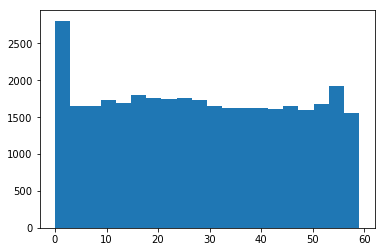

In [6]:
plt.hist(plays['Second'], bins=20);
print('unique values:', len(plays['Second'].unique()))

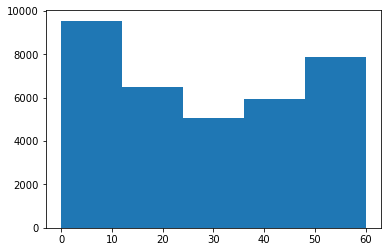

In [7]:
plays['BinnedSecond'] = plays['Second'].map(lambda x: round_nearest_int(x, 10))
plays['BinnedSecond'].head()
plt.hist(plays['BinnedSecond'], bins=5);

In [8]:
assert((plays['BinnedSecond'] % 10 == 0).all())
assert(len(set(plays['BinnedSecond']))==7)

### ToGo

unique values: 39


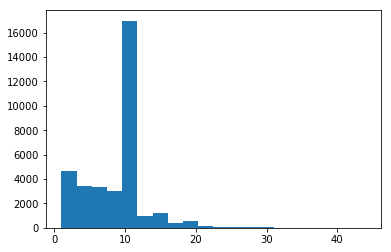

In [9]:
plt.hist(plays['ToGo'], bins=20);
print('unique values:', len(plays['ToGo'].unique()))

Rounding ToGo to the nearest ten preserves the most important aspects of the distribution while removing noise that would hamper a learning algorithm: 

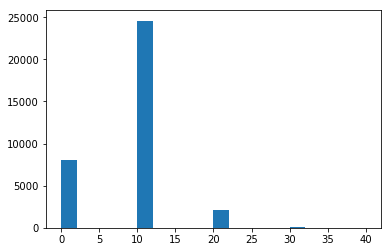

In [10]:
plays['BinnedToGo'] = plays['ToGo'].map(lambda x: round_nearest_int(x, 10))
plt.hist(plays['BinnedToGo'], bins=20);

In [11]:
assert((plays['BinnedToGo'] % 10 == 0).all())
assert(len(set(plays['BinnedToGo']))==5)

### YardLine

unique values: 99


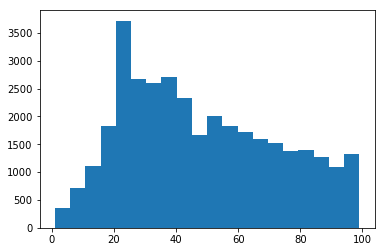

In [12]:
plt.hist(plays['YardLine'], bins=20);
print('unique values:', len(plays['YardLine'].unique()))

For YardLine the nearest 12 yard value seems to be a better rounding value than ten for preserving the shape of the distribution:

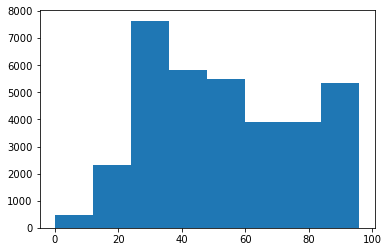

In [13]:
plays['BinnedYardLine'] = plays['YardLine'].map(lambda x: round_nearest_int(x, 12))
plt.hist(plays['BinnedYardLine'], bins=8);

In [14]:
assert((plays['BinnedYardLine'] % 12 == 0).all())

### YardLineFixed

unique values: 50


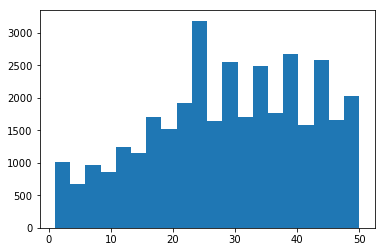

In [15]:
plt.hist(plays['YardLineFixed'], bins=20);
print('unique values:', len(plays['YardLineFixed'].unique()))

For YardLineFixed the nearest 5 yard value seems to be a better rounding value than ten for preserving the shape of the distribution:

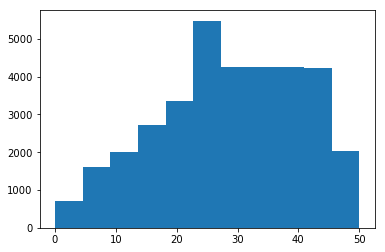

In [16]:
plays['BinnedYardLineFixed'] = plays['YardLineFixed'].map(lambda x: round_nearest_int(x, 5))
plt.hist(plays['BinnedYardLineFixed'], bins=11);

In [17]:
assert((plays['BinnedYardLineFixed'] % 5 == 0).all())

### Yards

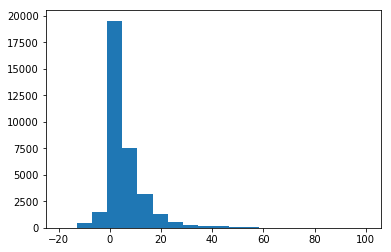

In [18]:
plt.hist(plays['Yards'], bins=20);

For the Yards column, binning to the nearest ten works well:

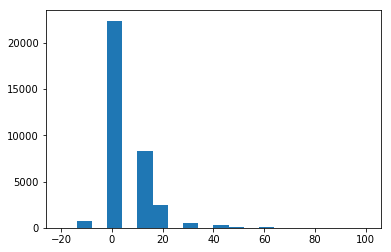

In [19]:
plays['BinnedYards'] = plays['Yards'].map(lambda x: round_nearest_int(x, 10))
plt.hist(plays['BinnedYards'], bins=20);

In [20]:
assert((plays['BinnedYards'] % 10 == 0).all())

We also add a SignYards column for the sign of yardage gain or loss:

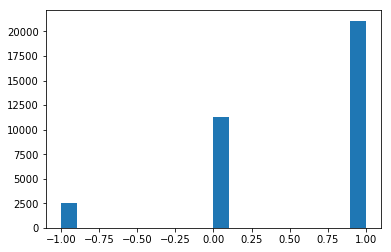

In [21]:
plays['SignYards'] = plays['Yards'].map(np.sign)
plt.hist(plays['SignYards'], bins=20);

### Encode String Features

String based features have to be encoded to numerial features in order for scikit-learn to be able to use them. One hot encoding is the preferred method because it prevents learning models from treating non-ordinal features as ordinal, but it cannot be used with variables that contain many classes because memory usage would skyrocket. A simple encoding from string to number will need to be used for OffenseTeam and DefenseTeam. All the other string features will be encoded using one hot encoding:

In [22]:
label_encoder = LabelEncoder()
plays['Enc_OffenseTeam'] = label_encoder.fit_transform(plays['OffenseTeam'])
plays['Enc_DefenseTeam'] = label_encoder.fit_transform(plays['DefenseTeam'])

The one-hot encodings below produce 30 columns! If we had one-hot encoded the teams data that would have added 62 more:

In [23]:
one_hot = pd.get_dummies(plays[['YardLineDirection', 'Formation', 'PlayType', 'PassType', 'RushDirection']],
                         prefix={'YardLineDirection':'YARDDIR', 'Formation':'FORM', 'PlayType':'PLAY', 'PassType':'PASS', 'RushDirection':'RUSHDIR'},
                         prefix_sep='_', drop_first=True)
plays = pd.concat([plays, one_hot], axis=1, join='inner')

In [24]:
file_path = work_dir + using_year + '-nfl-plays_final.csv'
plays.to_csv(file_path, index=False)

In [25]:
file_path = work_dir + using_year + '-nfl-plays_final.csv'
plays = pd.read_csv(file_path)
print('Columns:', ', '.join(plays.columns))

Columns: GameId, GameDate, Quarter, Minute, Second, OffenseTeam, DefenseTeam, Down, ToGo, YardLine, SeriesFirstDown, Description, Yards, Formation, PlayType, IsRush, IsPass, IsCompleted, IsTouchdown, PassType, IsSack, IsChallenge, IsChallengeReversed, IsInterception, IsFumble, RushDirection, YardLineFixed, YardLineDirection, GameMonth, BinnedSecond, BinnedToGo, BinnedYardLine, BinnedYardLineFixed, BinnedYards, SignYards, Enc_OffenseTeam, Enc_DefenseTeam, YARDDIR_OWN, FORM_NO HUDDLE, FORM_NO HUDDLE SHOTGUN, FORM_PUNT, FORM_SHOTGUN, FORM_UNDER CENTER, PLAY_DIRECT SNAP, PLAY_EXCEPTION, PLAY_FIELD GOAL, PLAY_FUMBLES, PLAY_PASS, PLAY_PUNT, PLAY_QB KNEEL, PLAY_RUSH, PLAY_SACK, PLAY_SCRAMBLE, PASS_DEEP MIDDLE, PASS_DEEP RIGHT, PASS_NOT APPLICABLE, PASS_SHORT LEFT, PASS_SHORT MIDDLE, PASS_SHORT RIGHT, PASS_UNKNOWN, RUSHDIR_LEFT END, RUSHDIR_LEFT GUARD, RUSHDIR_LEFT TACKLE, RUSHDIR_NOT APPLICABLE, RUSHDIR_RIGHT END, RUSHDIR_RIGHT GUARD, RUSHDIR_RIGHT TACKLE


## Machine Learning Classifiers

The following is a simple function that takes a feature dataframe, label series, and scikit-learn interface classifier and returns the average accuracy, precision, recall, and feature importance (if available) over k folds:

In [26]:
def KFoldClassification(features, labels, clf, numTimes=5, imp=True):
    kf = KFold(n_splits=numTimes, shuffle=True)
    accuracy = np.zeros(kf.get_n_splits())
    precision = np.zeros(kf.get_n_splits())
    recall = np.zeros(kf.get_n_splits())
    importances = pd.DataFrame()
    i=0
    for train_idx, test_idx in kf.split(features):
        train_feats = features.iloc[train_idx]
        train_labels = labels.iloc[train_idx]
        clf.fit(train_feats, train_labels)

        test_feats = features.iloc[test_idx]
        test_labels = labels.iloc[test_idx]
        predictions = clf.predict(test_feats)
        accuracy[i] = accuracy_score(test_labels, predictions)
        precision[i] = precision_score(test_labels, predictions, labels=test_labels.unique(), average='macro')
        recall[i] = recall_score(test_labels, predictions, labels=test_labels.unique(), average='macro')
        i += 1
        if (imp):
            importances[i] = clf.feature_importances_

    stats = pd.DataFrame({'accuracy': accuracy.mean(), 'precision': precision.mean(), 'recall': recall.mean()}, index=[0])
    avg_importance_df = None
    if (imp):
        avg_importance = importances.mean(axis=1)
        avg_importance_df = pd.DataFrame({'feature':features.columns, 'avg_importance':avg_importance}).sort_values('avg_importance', ascending=False)
    return stats, avg_importance_df

### Yardage Prediction

The following is an untuned model built to predict whether a play leads to a yardage gain (1), no advance (0), or a yardage loss (-1)

In [27]:
feats = plays[['GameMonth', 'Quarter', 'Minute', 'Second', 'BinnedSecond',
               'Down', 'ToGo', 'BinnedToGo', 'YardLine', 'BinnedYardLine',
               'YardLineFixed', 'BinnedYardLineFixed', 'IsPass', 'IsRush',
               'Enc_OffenseTeam', 'Enc_DefenseTeam',
               'YARDDIR_OWN',
               'FORM_NO HUDDLE', 'FORM_NO HUDDLE SHOTGUN', 'FORM_PUNT',
               'FORM_SHOTGUN', 'FORM_UNDER CENTER',
               'PLAY_DIRECT SNAP', 'PLAY_EXCEPTION', 'PLAY_FIELD GOAL', 'PLAY_FUMBLES', 'PLAY_PASS',
               'PLAY_PUNT', 'PLAY_QB KNEEL', 'PLAY_RUSH', 'PLAY_SACK', 'PLAY_SCRAMBLE',
               'PASS_DEEP MIDDLE', 'PASS_DEEP RIGHT', 'PASS_NOT APPLICABLE',
               'PASS_SHORT LEFT', 'PASS_SHORT MIDDLE', 'PASS_SHORT RIGHT', 'PASS_UNKNOWN',
               'RUSHDIR_LEFT END', 'RUSHDIR_LEFT GUARD', 'RUSHDIR_LEFT TACKLE',
               'RUSHDIR_NOT APPLICABLE', 'RUSHDIR_RIGHT END', 'RUSHDIR_RIGHT GUARD',
               'RUSHDIR_RIGHT TACKLE'
              ]]

In [28]:
labs = plays['SignYards']
stat, feat_imps = KFoldClassification(feats, labs, RandomForestClassifier())
print(stat)
feat_imps

   accuracy  precision    recall
0  0.714351    0.73467  0.600105


,avg_importance,feature
15,0.072847,Enc_DefenseTeam
3,0.072601,Second
14,0.070059,Enc_OffenseTeam
2,0.062300,Minute
8,0.058346,YardLine
5,0.056117,Down
10,0.054539,YardLineFixed
13,0.050818,IsRush
0,0.039014,GameMonth
6,0.038435,ToGo


From the above, we can see that most of the features do a poor job of segmenting the labels by their values. The precision value when compared to the recall shows that the classifer avoids false positives better than it can avoid false negatives (misses).

It looks like there is room to increase the accuracy of the model. Let's try tuning some of the hyperparameters:

In [29]:
labs = plays['SignYards']
stat, feat_imps = KFoldClassification(feats, labs, RandomForestClassifier(n_estimators=100, max_depth=5), imp=True)
print(stat)
feat_imps[:10]

   accuracy  precision    recall
0  0.739087   0.880852  0.573744


,avg_importance,feature
5,0.160367,Down
13,0.120632,IsRush
30,0.092829,PLAY_SACK
29,0.082229,PLAY_RUSH
42,0.080441,RUSHDIR_NOT APPLICABLE
19,0.076244,FORM_PUNT
27,0.072041,PLAY_PUNT
26,0.058456,PLAY_PASS
12,0.056451,IsPass
24,0.043391,PLAY_FIELD GOAL


In [30]:
labs.value_counts(normalize=True)

 1    0.604718
 0    0.322193
-1    0.073089
Name: SignYards, dtype: float64

Increasing the number of estimators results in a more "fitted" model, and thus increases the accuracy and brings precision over 80%. Limiting the maximum depth of the tree prevents overfitting by reducing the usage of poor features (and weighting better features more) bringing the precision to about 88%.

There is a decrease in accuracy and precision when we combine the loss and no gain label classes, but there is a predictable increase in recall:

In [31]:
labs = plays['SignYards'].map(lambda x: 0 if x == -1 else x) #Treat losses and no yardage as the same
stat, feat_imps = KFoldClassification(feats, labs, RandomForestClassifier(n_estimators=100, max_depth=6))
stat

,accuracy,precision,recall
0,0.741208,0.848513,0.672888


In [32]:
labs.value_counts(normalize=True)

1    0.604718
0    0.395282
Name: SignYards, dtype: float64

We should note that along with the increase in recall, this model now answers a different question - instead of predicting the outcome loss, no gain, or gain the model now predicts the more general (and arguably more interesting) case of whether or not the play is "good". In other words, does the play advance (good) or not (bad).

Let's see what happens if we reduce the number of features to the top five:

In [33]:
imp_feat_list = list(feat_imps['feature'])
print(imp_feat_list)
labs = plays['SignYards'].map(lambda x: 0 if x == -1 else x) #Treat losses and no yardage as the same
stat, il = KFoldClassification(feats[imp_feat_list[:5]], labs, RandomForestClassifier(n_estimators=100, max_depth=6))
print(stat)
il

['Down', 'IsRush', 'PLAY_PUNT', 'RUSHDIR_NOT APPLICABLE', 'FORM_PUNT', 'PLAY_PASS', 'PLAY_SACK', 'IsPass', 'PLAY_RUSH', 'PASS_NOT APPLICABLE', 'PLAY_FIELD GOAL', 'PLAY_SCRAMBLE', 'PLAY_QB KNEEL', 'FORM_SHOTGUN', 'PASS_DEEP RIGHT', 'YardLine', 'FORM_UNDER CENTER', 'PASS_SHORT MIDDLE', 'PASS_SHORT LEFT', 'ToGo', 'BinnedYardLine', 'Minute', 'YardLineFixed', 'PASS_SHORT RIGHT', 'RUSHDIR_RIGHT GUARD', 'RUSHDIR_LEFT GUARD', 'BinnedYardLineFixed', 'Enc_DefenseTeam', 'Second', 'RUSHDIR_RIGHT TACKLE', 'YARDDIR_OWN', 'RUSHDIR_LEFT TACKLE', 'Enc_OffenseTeam', 'PLAY_FUMBLES', 'FORM_NO HUDDLE SHOTGUN', 'BinnedToGo', 'Quarter', 'BinnedSecond', 'PLAY_EXCEPTION', 'RUSHDIR_LEFT END', 'GameMonth', 'RUSHDIR_RIGHT END', 'FORM_NO HUDDLE', 'PLAY_DIRECT SNAP', 'PASS_DEEP MIDDLE', 'PASS_UNKNOWN']
   accuracy  precision    recall
0  0.689472   0.806904  0.609188


,avg_importance,feature
0,0.382591,Down
1,0.296884,IsRush
2,0.147239,PLAY_PUNT
3,0.092871,RUSHDIR_NOT APPLICABLE
4,0.080416,FORM_PUNT


Not much of a decrease in performance. Now let's see what happens to accuracy, precision, and recall as we add less important features:

In [35]:
importance_stats = []
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40]:
    stat, garbage = KFoldClassification(feats[imp_feat_list[:i]], labs, RandomForestClassifier(n_estimators=100), imp=False)
    importance_stats.append({'features': i, 'accuracy':stat['accuracy'],'precision':stat['precision'],'recall':stat['recall']})
    print(i)
all_stats = pd.DataFrame(importance_stats)

1
2
3
4
5
6
7
8
9
10
20
30
40


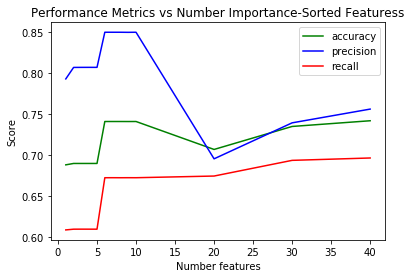

In [36]:
plt.plot(all_stats['features'], all_stats['accuracy'], color='green', label='accuracy')
plt.plot(all_stats['features'], all_stats['precision'], color='blue', label='precision')
plt.plot(all_stats['features'], all_stats['recall'], color='red', label='recall')
plt.xlabel('Number features')
plt.ylabel('Score')
plt.title('Performance Metrics vs Number Importance-Sorted Featuress')
plt.legend()
# plt.show()
plt.savefig('figures/YardClassifierPerformanceVsFeatures.png')

### Adaboosted Binary Yardage Classifier

AdaBoosting with a base DecisionTree estimator does not seem to improve performance:

In [38]:
best_features = imp_feat_list[:15]
labs = plays['SignYards'].map(lambda x: 0 if x == -1 else x) #Treat losses and no yardage as the same
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6),
                         algorithm="SAMME", n_estimators=80, learning_rate=1.0)
stat, imps = KFoldClassification(feats[best_features], labs, ada)
print(stat)
imps[5:]

   accuracy  precision    recall
0  0.748287   0.816245  0.687624


,avg_importance,feature
1,0.079907,IsRush
12,0.049827,PLAY_QB KNEEL
9,0.042601,PASS_NOT APPLICABLE
5,0.018531,PLAY_PASS
7,0.015077,IsPass
14,0.013374,PASS_DEEP RIGHT
3,0.008228,RUSHDIR_NOT APPLICABLE
13,0.005519,FORM_SHOTGUN
8,0.002188,PLAY_RUSH
4,0.000000,FORM_PUNT


### Binary Pass Completion Classifier

Now let's look at factors that can help predict a completed pass. First we need to remove the rows that are not pass plays and columns (features) that are irrlevant or will cause the model to cheat:

In [39]:
feats_pass = plays[plays['IsPass']==1][['GameMonth', 'Quarter', 'Minute', 'Second', 'BinnedSecond',
               'Down', 'ToGo', 'BinnedToGo', 'YardLine', 'BinnedYardLine',
               'YardLineFixed', 'BinnedYardLineFixed',
               'Enc_OffenseTeam', 'Enc_DefenseTeam',
               'YARDDIR_OWN',
               'FORM_NO HUDDLE', 'FORM_NO HUDDLE SHOTGUN', 'FORM_PUNT',
               'FORM_SHOTGUN', 'FORM_UNDER CENTER',
               'PASS_DEEP MIDDLE', 'PASS_DEEP RIGHT', 'PASS_NOT APPLICABLE',
               'PASS_SHORT LEFT', 'PASS_SHORT MIDDLE', 'PASS_SHORT RIGHT', 'PASS_UNKNOWN',
              ]]
labs_pass = plays[plays['IsPass']==1]['IsCompleted']

Let's build a RandomForestClassifer based model:

In [40]:
stat, feat_imps = KFoldClassification(feats_pass, labs_pass, RandomForestClassifier(n_estimators=200, max_depth=7), imp=True)
print(stat)
feat_imps[:5]

   accuracy  precision    recall
0  0.660934    0.62157  0.533871


,avg_importance,feature
21,0.170194,PASS_DEEP RIGHT
8,0.084629,YardLine
3,0.061311,Second
13,0.059339,Enc_DefenseTeam
12,0.058896,Enc_OffenseTeam


Unfortunately it looks like no amount of parameter tuning is able to get any of the metrics beyond the mid 60%. Let's try something else:

### Support vector machine (SVM) completion prediction

The support vector machine is one of the most powerful models in statistical machine learning. The main trouble behind it is that its hyper parameters are more difficult to tune to produce a useful model.

Here we are doing an exhaustive grid search to find the optimal values of the C and gamma hyperparameters with a rbf kernel support vector machine. Note that we are using the F1 (harmonic mean of precision and recall) as the value to optimize for. Note that the optimal values are saved in the notebook so that this code never needs to be run again:

In [10]:
parameters = {
    'C':            np.logspace(-3, 3, 7),
    'gamma':        np.logspace(-3, 3, 7)
    }

model = GridSearchCV(svm.SVC(), parameters, scoring=make_scorer(f1_score), cv=3, n_jobs=4)
model.fit(feats_pass, labs_pass)
print(model.best_estimator_)
print(model.best_score_)
print(model.best_params_)

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.788346186545
{'C': 0.001, 'gamma': 0.001}


model.best_estimator_: SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
  
model.best_score_: 0.788346186545

model.best_params_: {'C': 0.001, 'gamma': 0.001}

The grid search yields parameters for C and gamma that give us an F1 score of 78.8%!